In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
from scipy import stats
import ipywidgets as widgets
from scipy.fftpack import fft
from scipy.signal import welch
from detecta import detect_peaks
import time
import datetime
import random
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
import dill
import pywt
from collections import Counter
import pickle
import warnings
warnings.simplefilter("ignore")
from platform import python_version
print(python_version())

3.9.2


# Data Preparation

## Functions
The functions in the following code snippet read the acceleration and annotation data and store the 3 acceleration signals ($a_X$, $a_Y$, $a_Z$) in the $1_{st}$ 3 columns and their corresponding labels in the $4^{th}$ column in numpy arrays.

In [2]:
def readData(accDir, annotFile):
    files = os.listdir(accDir)
    files_csv = [f for f in files if f[-3:] == 'csv']
    empatica_dict = dict()
    for f in files_csv:
        data = np.genfromtxt(accDir+f, delimiter=',') # creates numpy array for each Empatica acc csv file
        key = int(float(f.strip("ACC.csv")))
        empatica_dict[key] = data
    tmp = pd.read_excel(annotFile, sheet_name=None)
    annot_dict = dict(zip(tmp.keys(), [i.dropna() for i in tmp.values()])) # Remove the rows with NaN values (some with ladder 2 missing)
    return empatica_dict, annot_dict

def getLabeledDict(empatica_dict, annot_dict, subject_ids):
    labeled_dict = {}; taskInd_dict = {}
    for id in subject_ids:
        start_time = int(empatica_dict[id][0,0])
        acc = empatica_dict[id][2:,:]
        label = list(map(lambda i: i.replace("_end", "").replace("_start", ""), annot_dict['P'+ str(id)].taskName.tolist()))
        task_time= list(map(lambda i: time.mktime(datetime.datetime.strptime(i[:6] + '20' + i[6:], "%m/%d/%Y %H:%M:%S").timetuple()),
                            annot_dict['P'+ str(id)].startTime_global.tolist()))
        task_ind = [int(x - start_time)*SR for x in task_time]
        taskInd_dict[id] = task_ind
        label_tmp = np.empty(acc.shape[0], dtype=object)
        for i, (j, k) in enumerate(zip(task_ind[0::2], task_ind[1::2])):
            tmpInd = 2*i
            label_tmp[j:k] = label[tmpInd]
        labeled_dict[id] = np.hstack((acc, label_tmp.reshape(label_tmp.shape[0],1)))
    return labeled_dict, taskInd_dict

## Create Dictionaries of Labeled Numpy Arrays for each Subject
In the following code chunk we use our functions to store the sessions' data in a dictionary with the subject numbers as keys.

In [3]:
sepAccDict, sepAnnotDict = readData(accDir='./Data/Acc Data/separate/', annotFile='./Data/Annotation Data/separate.xlsx')
SR=int(sepAccDict[8][1,0]) # sampling rate
sepSubIDs = list(range(8,45))
sepLabeledDict, sepTaskIndDict = getLabeledDict(sepAccDict, sepAnnotDict, sepSubIDs)

## Visualize Signals with the Task Start and End for Each Subject

### Plotting Function

In [4]:
def plotSigAnnot(labeled_dict, taskInd_dict, id, figSize):
    f, axs = plt.subplots(3,1,figsize=figSize)
    axs[0].plot(labeled_dict[id][:,0])
    for v in taskInd_dict[id]:
        axs[0].axvline(v, c="r", linewidth=1)
    axs[0].set_title("$a_X$", fontsize=30)

    axs[1].plot(labeled_dict[id][:,1])
    for v in taskInd_dict[id]:
        axs[1].axvline(v, c="r", linewidth=1)
    axs[1].set_title('$a_Y$', fontsize=30)

    axs[2].plot(labeled_dict[id][:,2])
    for v in taskInd_dict[id]:
        axs[2].axvline(v, c="r", linewidth=1)
    axs[2].set_title('$a_Z$', fontsize=30)
    
    return f

### Show all Subjects in Tabs
**Note:** This code only works with ipywidgets. Also, note the tabs cannot be saved in the notebooks and only show up if you run the code on your local machine.

In [ ]:
sub_tab=[widgets.Output() for i in range(len(sepSubIDs))]
tab = widgets.Tab(sub_tab)
for i, id in enumerate(sepSubIDs):
    tab.set_title(i,"sub {}".format(id))
    with sub_tab[i]:
        f = plotSigAnnot(sepLabeledDict, sepTaskIndDict, id=id, figSize=(20,14))
        plt.show(f)
display(tab)

### Plot a Separate Session for a Sample Subject

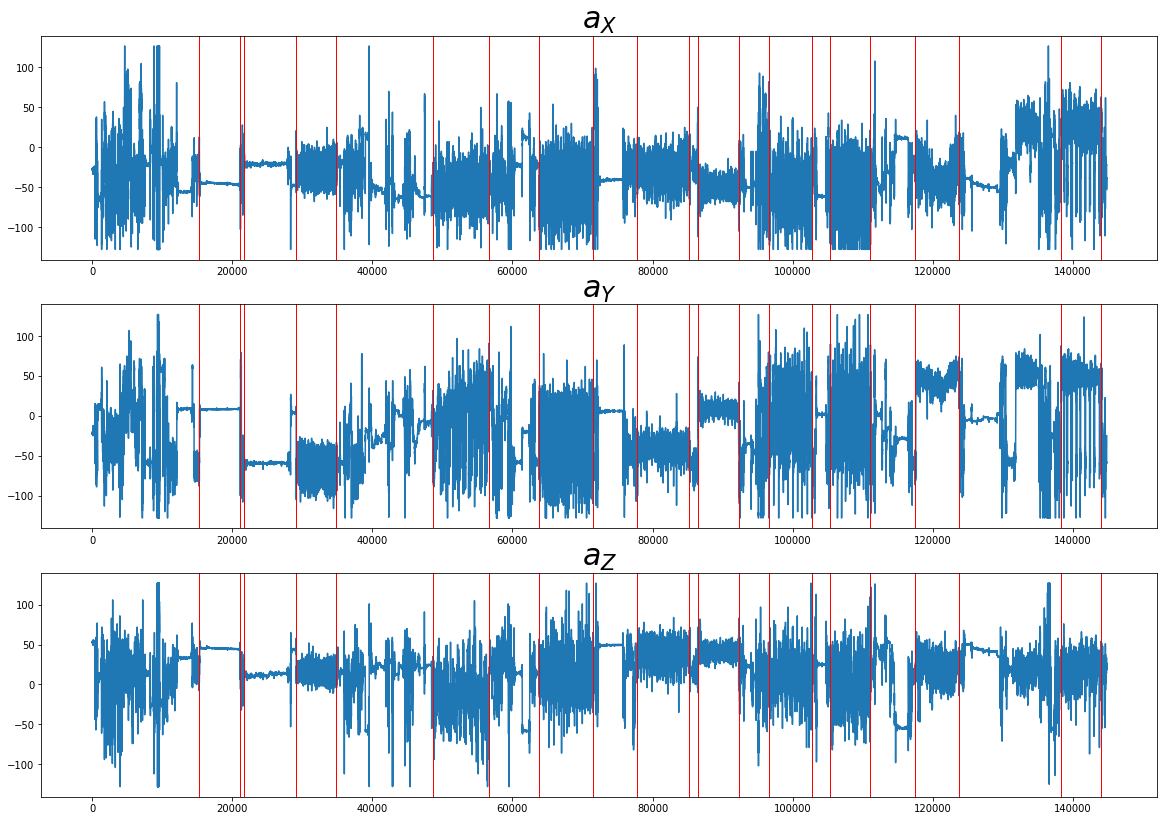

In [5]:
f = plotSigAnnot(sepLabeledDict, sepTaskIndDict, id=15, figSize=(20,14))

# Feature Engineering

## Create Signal Arrays
The **getArrDict** function in the following code chunk, extracts certain length of the acceleration signals for each subject and store them in 3D numpy arrays of shape (**a**, **b**, **c**). Here **a** is the number of windows, **b** is the window length (320 or 128), and **c** is the number of signals plus one ($a_X$, $a_Y$, $a_Z$, and *label*).

We will use this function to create arrays with different window lengths.

In [6]:
def getArrDict(labeledDict, subject_ids, windowLen):
    ArrDict = {}
    for id in subject_ids:
        df = pd.DataFrame(data=labeledDict[id], columns=['aX', 'aY', 'aZ', 'label'])
        grDict = dict(tuple(df.groupby(by='label'))) # dict values are pd DF's
        sigArr = np.zeros((0, windowLen, 4))
        for key in grDict.keys():
            task_df = grDict[key]
            tmp1 = [task_df.iloc[i:i+windowLen, :] for i in range(0, task_df.shape[0], windowLen)]
            if len(tmp1[-1]) != windowLen: del tmp1[-1]
            sigArr = np.vstack((sigArr, np.array(tmp1)))
        ArrDict[id] = sigArr
    return ArrDict

## Windowing and Generating Time and Frequency Domain Features

We labeled the acceleration signals and segmented the annotated signals into equal length windows. There are multiple windowing strategies including non-overlapping sliding windows, overlapping sliding windows, event-defined windows, and activity-defined windows. We use the non-overlapping sliding window approach which moves a fixed length window over the signals. The window lengths were selected based on the sensor's sampling rate and the complexity of the tasks. While smaller windows can result in faster activity recognition, larger windows are better suited for recognition of complex activities. Considering the complexity of the activities and the use of a single accelerometer, we selected two different window lengths of 4 and 10 seconds, equivalent to 128 and 320 data points in the acceleration signal (sampling rate of 32 Hz).

## Create Feature-Label Data Frames
In the follwing code snippet we define a function to generate the time, frequency, and time-frequency features for each window. For the time domain features we first removed the high frequency noise by applying a $4^{th}$ order low pass Butterworth filter with a cutoff frequency of 10 Hz on the three acceleration signals within each window. Next, we calculated 9 statistics for each of the three filtered signals within the window. These statistics included mean and root mean square (RMS) to capture the central tendency of the signal, mean average deviation (MAD) and standard deviation ($\sigma_x$) to represent the signal dispersion, and minimum, maximum, median, $25^{th}$ percentile, and $75^{th}$ percentile as the summary statistics of the signal. The 9 statistics per signal summed up to a total of 27 time domain features for each window/observation.

For the frquency features we used the Fourier tranform on the 3 acceleration signals in each window. Since the higher frequencies are associated with noise, we only use the FFT coefficieents at frequencies less than 10 Hz. This alows us to skip low pass filtering in pre-processing. The function produces 2 outputs. This resulted in feature vectors of length 120 and 300 for the 4 and 10 second windows, respectively.

For the time-frequency domain features we used discrete wavelet transform (DWT). The DWT features are more reliable for modelling non-stationary acceleration signals~\citep{tian2020robust}. We used a Daubechies-4 mother wavelet (db 4) with the filter bank approach to decompose the original signals to approximation (cA) and detail (cD) coefficients. The decomposition was applied up to the maximum possible level on the three acceleration signals (4 and 5 levels for the cases of 4 and 10 second windows, respectively). To reduce the dimension of the wavelet coefficeints, entropy, number of zero- and mean-crossings, and the 9 statistics used for time features were calculated for the last approximation coefficients and all detail coefficients and were concatenated to generate the time-frequency domain features. This resulted in features with the lengths of 180 and 216 for the 4 and 10 second windows, respectively.

In [7]:
def applyFilter(sig, SR, n, fc):
    w = fc/(SR/2)
    b, a = signal.butter(n, w, 'low')
    filteredSig = signal.filtfilt(b, a, sig)
    return filteredSig

def fftCalc(sig, sampRate, windowLen):
    f_values = np.linspace(0, sampRate/2, windowLen//2)
    fft_values = 2/windowLen * np.abs(fft(sig)[0:windowLen//2])
    filtered_f = f_values[f_values<10]
    filtered_fft = fft_values[f_values<10]
    return filtered_f, filtered_fft

def fftPeaks(sig, filtered_f, filtered_fft, percentile, denominator, sampRate, no_peaks):
    signal_min = np.percentile(sig, percentile)
    signal_max = np.percentile(sig, 100-percentile)
    mph = (signal_max - signal_min)/denominator # minimum peak height
    indices_peaks = detect_peaks(filtered_fft, mph=mph)
    if len(indices_peaks) >= no_peaks:
        peakFeatures = list(filtered_f[indices_peaks])[:no_peaks] + list(filtered_fft[indices_peaks])[:no_peaks]
    else:
        missing = no_peaks-len(indices_peaks)
        peakFeatures = list(filtered_f[indices_peaks])+[0]*missing + list(filtered_fft[indices_peaks])+[0]*missing
    peakFeatures.append(filtered_fft[0])
    return peakFeatures

def getStats(sig):
    mean_ = np.mean(sig)
    rms_ = np.sqrt(np.mean(np.square(sig)))
    mad_ = np.mean(np.absolute(sig-np.mean(sig)))
    std_ = np.std(sig)
    min_ = min(sig)
    max_ = max(sig)
    med_ = np.percentile(sig, 50)
    perc25 = np.percentile(sig, 25)
    perc75 = np.percentile(sig, 75)
    stats_ = [mean_, rms_, mad_, std_, min_, max_, med_, perc25, perc75]
    return stats_

def getCrossings(sig):
    zeroCross = np.count_nonzero(np.diff(np.sign(sig)))
    centeredSig = sig - np.mean(sig)
    meanCross = np.count_nonzero(np.diff(np.sign(centeredSig)))
    return [zeroCross, meanCross]

def getEntropy(sig):
    count = Counter(sig).most_common()
    probability = [elem[1]/len(sig) for elem in count]
    return [stats.entropy(probability)]

def extract_features_dicts(dataset, windowLen, sampRate, denominator, no_peaks, waveletName, featureSet, percentile=5):
    list_of_features = []
    for samp_no in range(0, dataset.shape[0]):
        features = []
        for sig_comp in range(0, dataset.shape[2] - 1):
            signal = dataset[samp_no, :, sig_comp]
            if featureSet == 'Time':
                features += getStats(applyFilter(signal, SR=sampRate, n=4, fc=10))
            elif featureSet == 'FrequencyAll':
                filtered_f, filtered_fft = fftCalc(signal, sampRate, windowLen)
                features += list(filtered_fft)
            elif featureSet == 'FrequencyPeaks':
                filtered_f, filtered_fft = fftCalc(signal, sampRate, windowLen)
                features += fftPeaks(signal, filtered_f, filtered_fft, percentile, denominator, sampRate, no_peaks)
            elif featureSet == 'TimeFrequency':
                waveletCoeffs = pywt.wavedec(signal, waveletName)
                for coeff in waveletCoeffs:
                    features += getStats(coeff) + getEntropy(coeff) + getCrossings(coeff)
            
        modifiedLabel = ''.join([i for i in dataset[samp_no, 0, 3] if not i.isdigit()]) # remove any numbers from label
        features.append(modifiedLabel) # Add modified label as last column
        list_of_features.append(features)
    features_df = pd.DataFrame(np.array(list_of_features), columns=list(range(1, len(list_of_features[0]))) + ['label'])
    return features_df

## Visualize Signals for Different Tasks

In [8]:
windowLen = 320 # 128
feature = 'Time'
sepArrDict = getArrDict(sepLabeledDict, sepSubIDs, windowLen)
features_df = {}
for key in sepArrDict.keys():
    features_df[key] = extract_features_dicts(dataset=sepArrDict[key], windowLen=windowLen, sampRate=SR, denominator=15,
                                                                 no_peaks=5, waveletName='db4', featureSet=feature, percentile=5)

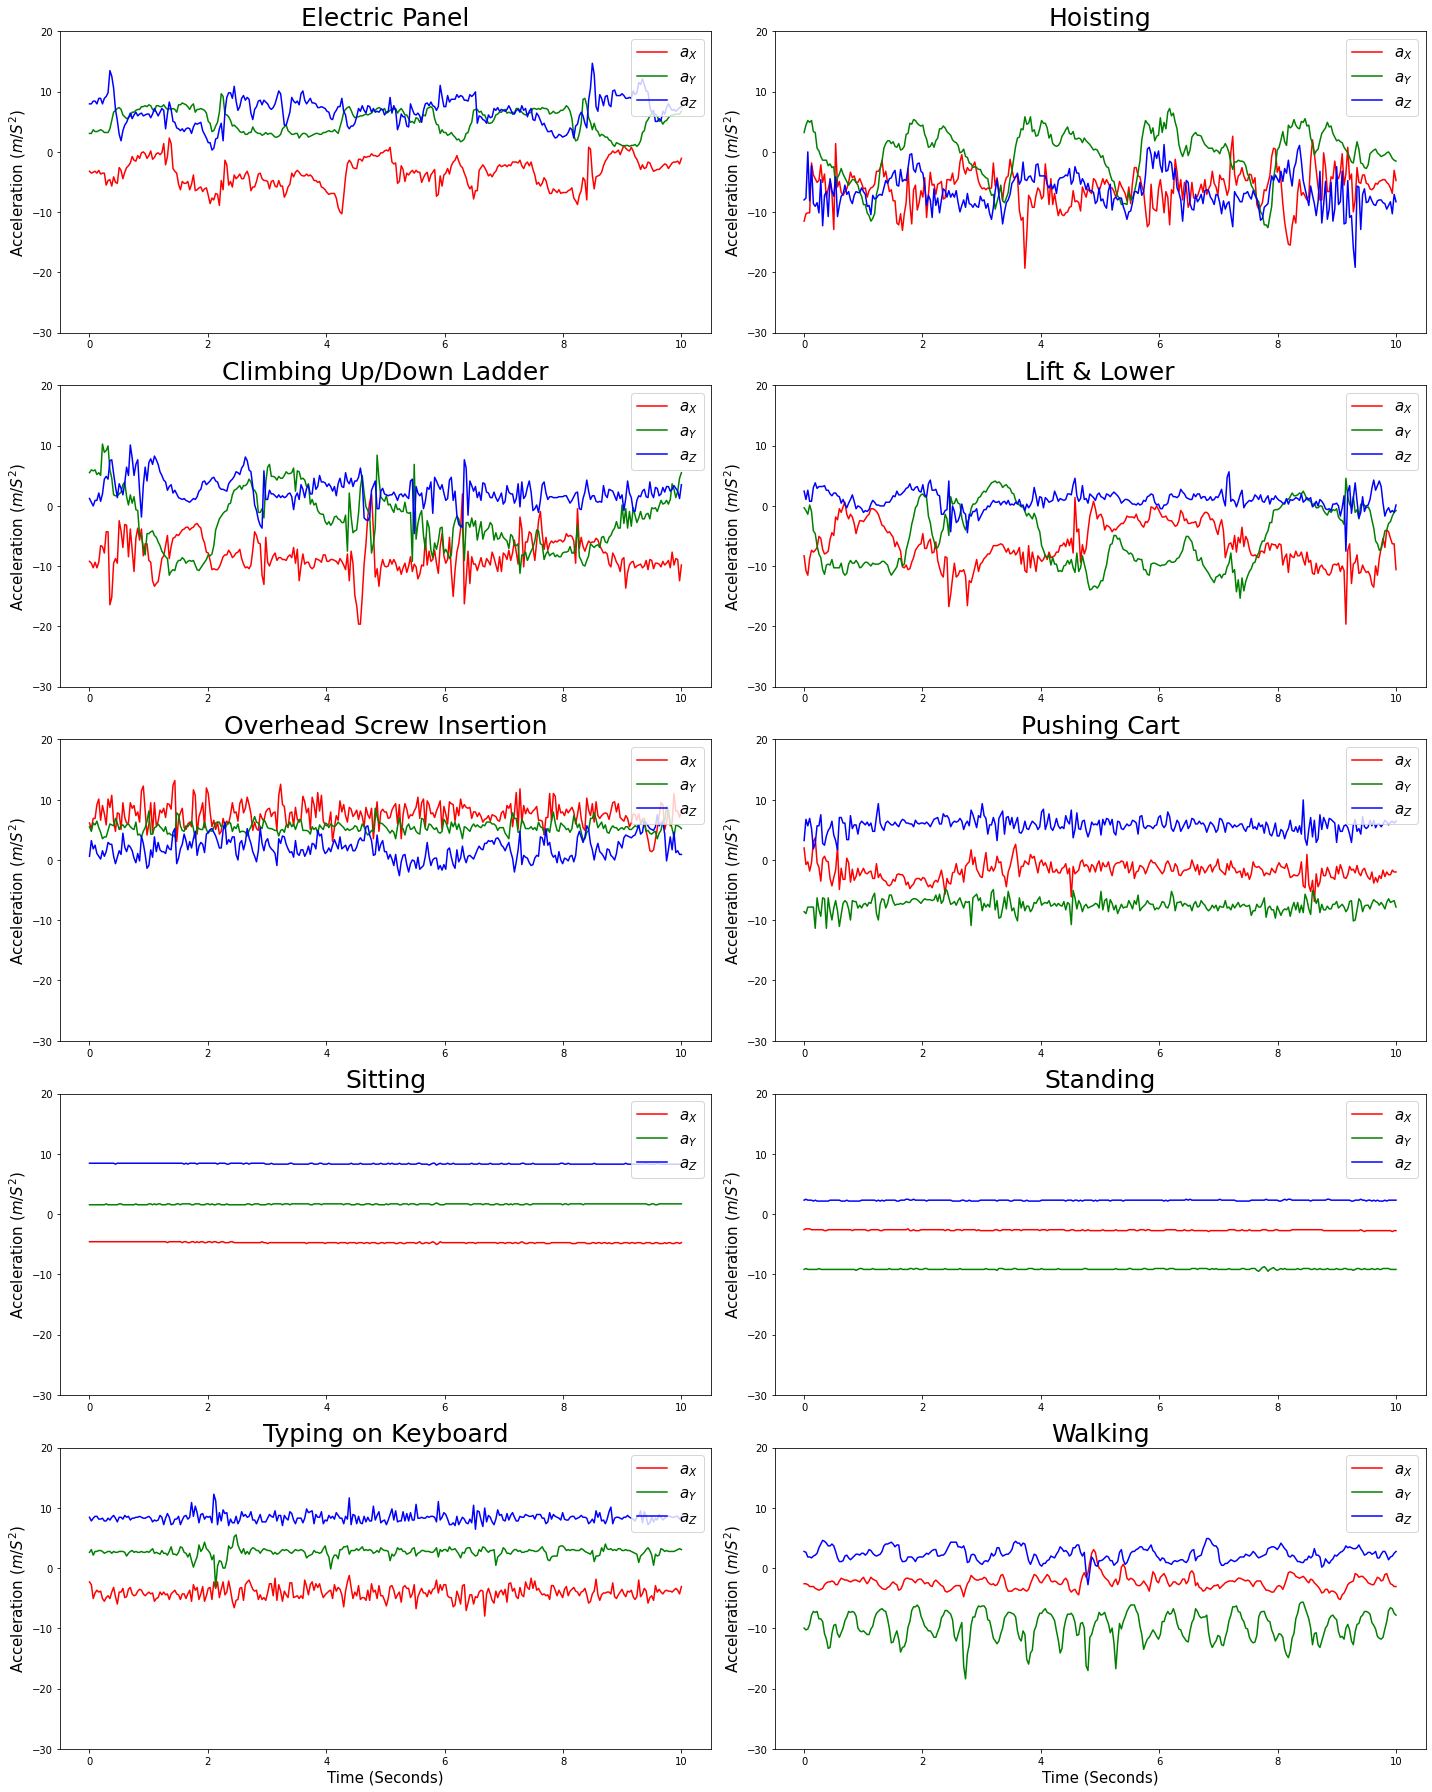

In [9]:
sub = 8
labs = np.unique(sepArrDict[sub][:,0,3])
Idx = [np.min(np.where(sepArrDict[sub][:,0,3]==lab)) for lab in labs if lab!='ladder2']
actList = ['Electric Panel', 'Hoisting', 'Climbing Up/Down Ladder', 'Lift & Lower', 'Overhead Screw Insertion', 'Pushing Cart', 'Sitting', 'Standing', 'Typing on Keyboard', 'Walking']
f, ax  = plt.subplots(5, 2, figsize=(20,25))
ax = ax.ravel()
for i, (ID, act) in enumerate(zip(Idx, actList)):
    act = ''.join([i for i in act if not i.isdigit()])
    ax[i].plot(np.linspace(0, windowLen/SR, windowLen), sepArrDict[sub][ID+1,:,0]*9.81/64, c='r', label='$a_X$')
    ax[i].plot(np.linspace(0, windowLen/SR, windowLen), sepArrDict[sub][ID+1,:,1]*9.81/64, c='g', label='$a_Y$')
    ax[i].plot(np.linspace(0, windowLen/SR, windowLen), sepArrDict[sub][ID+1,:,2]*9.81/64, c='b', label='$a_Z$')
    ax[i].legend(loc='upper right', prop={'size': 15})
    ax[i].set_title(act, fontsize=25)
    ax[i].set_ylim([-30, 20])
    ax[i].set_ylabel('Acceleration ($m/S^2$)', fontsize=15)
    if i==8 or i==9:
        ax[i].set_xlabel('Time (Seconds)', fontsize=15)
f.tight_layout()
f.savefig('./allAccSignals.png', bbox_inches='tight')
plt.show()

# Classification
## Intra-Subject
In the following code chunk we define the **splitTrainTest_1** function to split the train and test data as follows:
1. Train and test on 1 subject
2. Select 80% of each task (from 1 subject) as training and the rest 20% (for the same subject) as testing

We used stratified sampling of each activity, to ensure balanced distribution of labels. This function will be called in the code chunks where we evaluate the ML models. This is the simplest implementation as we train and test our models on the same subject and therefore, we expect high accurecy.

In [17]:
def splitTrainTest_1(featureDict, subID, percentTrain):
    random.seed(1365)
    feature_df = featureDict[subID]
    indList = [list(x.index) for x in dict(list(feature_df.groupby(by='label'))).values()]
    tmp = list(map(lambda i: random.sample(indList[i], k=int(percentTrain*len(indList[i]))), range(len(indList)))) # get 80% of data from each label
    trainInd = [x for l in tmp for x in l]
    testInd = list(set(feature_df.index) - set(trainInd))
    X_train = feature_df.loc[trainInd, feature_df.columns != 'label'].astype(float).to_numpy()
    Y_train = feature_df.loc[trainInd, 'label'].to_numpy()
    X_test = feature_df.loc[testInd, feature_df.columns != 'label'].astype(float).to_numpy()
    Y_test =feature_df.loc[testInd, 'label'].to_numpy()
    return X_train, Y_train, X_test, Y_test

In the following code snippet we perform the classification using the *k*-Nearest Neighbors (*k*-NN), Support Vectors Machine (SVM), and Random Forest (RF) classifiers. In the intra-ssubject classification workflow is designed in a personalized way, where the training and testing sets are from the same individual. Here we aim to investigate the performance of the classifier, feature set, and window length combinations in the intra-subject scenario.

Here we tune the classifiers' hyper-parameters using 10-fold cross validation and grid search. For the *k*-NN classifier, the grid search is performed for the number of neighbors (from 1 to 28 by increments of 3), the distance metric (Euclidean and Manhattan), and the weight (uniform and distance). For the SVM classifier the grid search is performed on the regularization parameter C (from 0.01 to 50), and the kernel (linear, polynomial, RBF, and Sigmoid). Also, for the RF classifier we perform the grid search on the maximum depth of the trees (5, 10, 20, 30, 40), and the number of features to consider for best split (20, 30, 40, 50, 60). The hyper-parameter tuning is performed for each participant independently. As we save the trained models for all subjects and combinations of classifiers, features, and window lengths this results in saving 666 files to be used in [evaluate_performance.ipynb](evaluate_performance.ipynb) notebook.

In [ ]:
startTime = time.time()
windowLenList = [128, 320]
featureList = ['Time', 'FrequencyAll', 'TimeFrequency']
classifierList = ['KNN', 'SVC', 'RandomForest']
for windowLen in windowLenList:
    print('Window Length: ', windowLen)
    for feature in featureList:
        print('Feature: ', feature)
        sepArrDict = getArrDict(sepLabeledDict, sepSubIDs, windowLen)
        features_df = {}
        for key in sepArrDict.keys():
            features_df[key] = extract_features_dicts(dataset=sepArrDict[key], windowLen=windowLen, sampRate=SR, denominator=15,
                                                                         no_peaks=5, waveletName='db4', featureSet=feature, percentile=5)
        for classifier in classifierList:
            print('Classifier: ', classifier)
            if classifier == 'RandomForest':
                train_accuracy = []; test_accuracy = []
                for key in features_df.keys():
                    X_train, Y_train, X_test, Y_test = splitTrainTest_1(features_df, subID=key, percentTrain=0.8)

                    clf = RandomForestClassifier()
                    max_depth = [5, 10, 20, 30, 40]
                    max_features = [20, 30, 40, 50, 60]
                    grid = dict(max_depth=max_depth, max_features=max_features)
                    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1365)
                    grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
                    grid_result = grid_search.fit(X_train, Y_train)
                    clf_best = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=10, random_state=1365,
                                                 max_depth=grid_result.best_params_['max_depth'], max_features=grid_result.best_params_['max_features'])
                    clf_best.fit(X_train, Y_train)
                    Y_pred = clf_best.predict(X_test)
                    TruePredY = pd.DataFrame(np.vstack((Y_test, Y_pred)).T, columns=['True', 'Predicted'])
                    filePickle = open('./outputs/classification/intra-subject/' + feature + '_' + classifier + '_' + str(windowLen) + '_Subject-' + str(key) + '.pickle', 'ab')
                    pickle.dump(dict(grid_result=grid_result, clf_best=clf_best, TruePredY=TruePredY), filePickle)
                    filePickle.close()
                
            elif classifier == 'KNN':
                train_accuracy = []; test_accuracy = []
                for key in features_df.keys():
                    X_train, Y_train, X_test, Y_test = splitTrainTest_1(features_df, subID=key, percentTrain=0.8)
                    X_train_scale = preprocessing.scale(X_train)
                    X_test_scale = preprocessing.scale(X_test)
                    clf = KNeighborsClassifier()
                    n_neighbors = range(1, 30, 3)
                    weights = ['uniform', 'distance']
                    metric = ['euclidean', 'manhattan']
                    grid = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)
                    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1365)
                    grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
                    grid_result = grid_search.fit(X_train_scale, Y_train)
                    clf_best = KNeighborsClassifier(n_neighbors=grid_result.best_params_['n_neighbors'], weights=grid_result.best_params_['weights'],
                                                    metric=grid_result.best_params_['metric'])
                    clf_best.fit(X_train_scale, Y_train)
                    Y_pred = clf_best.predict(X_test_scale)
                    TruePredY = pd.DataFrame(np.vstack((Y_test, Y_pred)).T, columns=['True', 'Predicted'])
                    
                    filePickle = open('./outputs/classification/intra-subject/' + feature + '_' + classifier + '_' + str(windowLen) + '_Subject-' + str(key) + '.pickle', 'ab')
                    pickle.dump(dict(grid_result=grid_result, clf_best=clf_best, TruePredY=TruePredY), filePickle)
                    filePickle.close()
                
            elif classifier == 'SVC':
                train_accuracy = []; test_accuracy = []
                for key in features_df.keys():
                    X_train, Y_train, X_test, Y_test = splitTrainTest_1(features_df, subID=key, percentTrain=0.8)
                    X_train_scale = preprocessing.scale(X_train)
                    X_test_scale = preprocessing.scale(X_test)
                    clf = SVC()
                    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
                    C = [50, 10, 1.0, 0.1, 0.01]
                    grid = dict(kernel=kernel,C=C)
                    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1365)
                    grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)

                    grid_result = grid_search.fit(X_train_scale, Y_train)
                    clf_best = SVC(kernel=grid_result.best_params_['kernel'], C=grid_result.best_params_['C'])
                    clf_best.fit(X_train_scale, Y_train)
                    Y_pred = clf_best.predict(X_test_scale)
                    TruePredY = pd.DataFrame(np.vstack((Y_test, Y_pred)).T, columns=['True', 'Predicted'])
                    
                    filePickle = open('./outputs/classification/intra-subject/' + feature + '_' + classifier + '_' + str(windowLen) + '_Subject-' + str(key) + '.pickle', 'ab')
                    pickle.dump(dict(grid_result=grid_result, clf_best=clf_best, TruePredY=TruePredY), filePickle)
                    filePickle.close()
print('Elapsed Time = ', time.time() - startTime)

## Inter-Subjects
Since we eventually want to train the algorithms on certain data and classify the tasks in unseen subjects here we split the train and test as follows:

1. Train on 80% of all subjects and test on 20% of remaining subjects
2. Select 100% of the tasks from 80% of all subjects as training and 100% of the tasks from the rest 20% of subjects as testing

This would be the most important and challenging since different individuals may perform the tasks differently. If we get high accuracy here, it shows that we can efficiently predict the tasks in new subjects. In the following two code chunks we split the data for training and testing. Moreover we define a function to split the training data into training and validation subjects in a 10-fold cross-validation for the grid search. For the purpose of cross-validation we concatenated the subject ids as the last column of the feature data frame. Next, in the *intersubjectcv* function for a k-fold cross validation split we use the *predefinedSplit* from sklearn in combination with a custom *test_fold* vector that is generated by assigning the same value to the samples from every n subjects (n = number-of-subjects/k) in each fold.

In [10]:
def splitTrainTest_3(featureDict, trainSub, testSub):
    test_df = pd.concat([featureDict[x] for x in testSub]).reset_index().drop(['index'], axis=1)
    X_test = test_df.loc[:, test_df.columns != 'label']
    Y_test = test_df.label
    trainDict = {}
    for key in trainSub:
        trainDict[key] = featureDict[key]
        trainDict[key]['subID'] = key
    train_df = pd.concat([trainDict[x] for x in trainDict.keys()]).reset_index().drop(['index'], axis=1)
    X_train = train_df.drop(['label', 'subID'], axis=1)
    Y_train = train_df.label
    return train_df, X_train, Y_train, X_test, Y_test

In [11]:
def intersubjectcv(train_df, kfold):
    validationIDs = np.array_split(np.unique(train_df.subID), kfold)
    test_fold = np.zeros(train_df.shape[0])
    for i in range(kfold):
        test_fold[np.isin(train_df.subID, validationIDs[i])] = i
    return PredefinedSplit(test_fold)

Below, we perform the classification for all the combinations of classifiers, feature sets, and the window lengths using the splitting strategies explained previously. Similar to the intra-subject scenario, we save the trained models in pickle files for generating the performance metrics. In the inter-subject scenario the number of files that we save sum up to 18 that are used in [evaluate_performance.ipynb](evaluate_performance.ipynb) notebook.

In [ ]:
random.seed(1365)
sub_list = list(features_df.keys())
random.shuffle(sub_list)
sub_fold = [sub_list[i::n] for i in range(n)]
for fold_idx, test_subs in enumerate(sub_fold):

In [21]:
sub_fold

[[26, 32, 21, 9, 13, 20, 12, 24],
 [41, 37, 42, 35, 43, 11, 23, 39],
 [14, 22, 18, 17, 28, 33, 38],
 [34, 19, 44, 31, 29, 40, 27],
 [16, 30, 8, 10, 15, 25, 36]]

In [20]:
startTime = time.time()

windowLenList = [128, 320]
featureList = ['Time', 'FrequencyAll', 'TimeFrequency']
classifierList = ['KNN', 'SVC', 'RandomForest']

n = 5
random.seed(1365)
sub_list = list(features_df.keys())
random.shuffle(sub_list)
sub_fold = [sub_list[i::n] for i in range(n)]
for fold_idx, test_subs in enumerate(sub_fold):
    print('------------------------------------------> Fold: ', fold_idx)
    train_subs = list(set(sub_list) - set(test_subs))
    
    for windowLen in windowLenList:
        print('Window Length: ', windowLen)
        for feature in featureList:
            print('Feature: ', feature)
            sepArrDict = getArrDict(sepLabeledDict, sepSubIDs, windowLen)
            features_df = {}
            for key in sepArrDict.keys():
                features_df[key] = extract_features_dicts(dataset=sepArrDict[key], windowLen=windowLen, sampRate=SR, denominator=15,
                                                                             no_peaks=5, waveletName='db4', featureSet=feature, percentile=5)
            train_df, X_train, Y_train, X_test, Y_test = splitTrainTest_3(features_df, train_subs, test_subs)
            X_train_scale = preprocessing.scale(X_train)
            X_test_scale = preprocessing.scale(X_test)
            for classifier in classifierList:
                print('Classifier: ', classifier)
                if classifier == 'RandomForest':
                    clf = RandomForestClassifier()
                    max_depth = [5, 10, 20, 30, 40]
                    max_features = [20, 30, 40, 50, 60]
                    grid = dict(max_depth=max_depth, max_features=max_features)
                    ps = intersubjectcv(train_df, kfold=10)
                    grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=ps, scoring='accuracy', error_score=0)
                    grid_result = grid_search.fit(X_train, Y_train)
                    clf_best = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=10, random_state=1365,
                                             max_depth=grid_result.best_params_['max_depth'], max_features=grid_result.best_params_['max_features'])
                    clf_best.fit(X_train, Y_train)
                    Y_pred = clf_best.predict(X_test)

                elif classifier == 'KNN':
                    clf = KNeighborsClassifier()
                    n_neighbors = range(1, 30, 3)
                    weights = ['uniform', 'distance']
                    metric = ['euclidean', 'manhattan']
                    grid = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)
                    ps = intersubjectcv(train_df, kfold=10)
                    grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=ps, scoring='accuracy', error_score=0)
                    grid_result = grid_search.fit(X_train_scale, Y_train)
                    clf_best = KNeighborsClassifier(n_neighbors=grid_result.best_params_['n_neighbors'], weights=grid_result.best_params_['weights'],
                                                metric=grid_result.best_params_['metric'])
                    clf_best.fit(X_train_scale, Y_train)
                    Y_pred = clf_best.predict(X_test_scale)

                elif classifier == 'SVC':
                    clf = SVC()
                    kernel = ['poly', 'rbf', 'sigmoid']
                    C = [50, 10, 1.0, 0.1, 0.01]
                    grid = dict(kernel=kernel,C=C)
                    ps = intersubjectcv(train_df, kfold=10)
                    grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=ps, scoring='accuracy', error_score=0)
                    grid_result = grid_search.fit(X_train_scale, Y_train)
                    clf_best = SVC(kernel=grid_result.best_params_['kernel'], C=grid_result.best_params_['C'])
                    clf_best.fit(X_train_scale, Y_train)
                    Y_pred = clf_best.predict(X_test_scale)

                TruePredY = pd.DataFrame(np.vstack((Y_test.values, Y_pred)).T, columns=['True', 'Predicted'])
                filePickle = open('./outputs/classification/inter-subject/' + 'Fold' + str(fold_idx+1) + '_' + feature + '_' + classifier + '_' + str(windowLen) + '.pickle', 'ab')
                pickle.dump(dict(grid_result=grid_result, clf_best=clf_best, TruePredY=TruePredY), filePickle)
                filePickle.close()
print('Elapsed Time = ', time.time() - startTime)

------------------------------------------> Fold:  0
Window Length:  128
Feature:  Time
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
Feature:  FrequencyAll
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
Feature:  TimeFrequency
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
Window Length:  320
Feature:  Time
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
Feature:  FrequencyAll
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
Feature:  TimeFrequency
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
------------------------------------------> Fold:  1
Window Length:  128
Feature:  Time
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
Feature:  FrequencyAll
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
Feature:  TimeFrequency
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
Window Length:  320
Feature:  Time
Classifier:  KNN
Classifier:  SVC
Classifier:  RandomForest
Feature:  Fre